In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
data = pd.read_csv('tweets_coronavirus.csv')
data.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
5153,10062,55014,"London, England",19-03-2020,What is wrong with people?\r\r\n\r\r\n#Coronav...,Extremely Negative
6726,11981,56933,"Seattle, WA",19-03-2020,Fred Meyer and QFC stores have reached an unde...,Positive
4622,9406,54358,Hollywood,19-03-2020,"@tranquileyes30 Grocery shopping, walking dog ...",Positive
12454,18894,63846,"Revelstoke, BC, Canada",22-03-2020,Finally leadership German chancellor Angela Me...,Positive
16908,24381,69333,NaN,25-03-2020,Gov. #Baker #prohibits #reusable #shopping #ba...,Negative


In [ ]:

data['Sentiment'].replace({"Negative": 0, "Extremely Negative": 0, "Positive": 1, "Extremely Positive": 1}, inplace=True)


data_diff = (data.groupby(['Sentiment']).size().max() - data.groupby(['Sentiment']).size().min()) / data.groupby(['Sentiment']).size().max() * 100
print("Разница: ", data_diff.round(), "%", sep ='')


Разница: 15.0%


То есть разница в количестве данных в классах составила всего 15%. Ранее было предположено считать, что классы сбалансированы при 30% и менее. Значит данные сбалансированы.

In [ ]:
from sklearn.impute import SimpleImputer
print("Количество пропусков в data:", data.isnull().sum())
replacer = SimpleImputer(strategy = "constant", fill_value="unknown")
data_nomiss = pd.DataFrame(data = replacer.fit_transform(data), columns=data.columns
)



Количество пропусков в data: UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
target = data_nomiss['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    data_nomiss, target, test_size=0.3, random_state=0
)





In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt", quiet=True)
from nltk.corpus import stopwords
nltk.download("stopwords", quiet=True)


True

In [ ]:
tokens = {}


for i in X_train['OriginalTweet']:
  token = i.lower().split()
  for j in token:
    if j in tokens:
      tokens[j] += 1
    else:
      tokens[j] = 1

print(len(tokens))



79753


In [ ]:
sorted_tokens = sorted(tokens.items(), key=lambda x: x[1], reverse=True)
sorted_10 = sorted_tokens[:10]

for key, value in sorted_10:
    print(f"{key}: {value}")

the: 26815
to: 23373
and: 14684
of: 13012
a: 11737
in: 11198
for: 8566
#coronavirus: 8223
is: 7383
are: 7050


Эти токены в топе потому что по сути являются словами несущими минимальную смысловую нагрузку, но тем не менее выполняющие роль связи других слов. "to", "and", "of", "for" - это предлоги, которые используются часто в разных предложениях вне зависимости от контекста. Также "the" и "a" частицы указатели в английском языке. "is" и "are" также используются везде и в большом количестве так как это формы настоящего времени в английском языке и без них невозможно построить предложение."#coronavirus" хэштег, который описывает наш топик, почти все твиты будут так или иначе с ним связаны.

In [ ]:
from nltk.corpus import stopwords
tokens_to_del = stopwords.words("english")

for i in tokens_to_del:
  if i in tokens:
    del tokens[i]


In [ ]:
sorted_tokens = sorted(tokens.items(), key=lambda x: x[1], reverse=True)
sorted_10 = sorted_tokens[:10]

for key, value in sorted_10:
    print(f"{key}: {value}")

#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314


Здесь почти все слова относятся к нашему топику, подходят по смыслу. Связаны с ценой, продуктами, магазинами, с переживаниями людей в то время.

In [ ]:
sorted_tokens = sorted(tokens.items(), key=lambda x: x[1])
sorted_20 = sorted_tokens[:20]

for key, value in sorted_20:
    print(f"{key}: {value}")



https://t.co/1m881cwfuv: 1
happy..: 1
https://t.co/z0intks34x: 1
mnuchinâs: 1
brink.: 1
https://t.co/jmobv8z0u0: 1
university's: 1
teaching.): 1
@catholicpres: 1
@catholicuniv: 1
https://t.co/evqby035wf: 1
https://t.co/riqrhxxeim: 1
@@ballardspahrll: 1
#aca: 1
easier...take: 1
ânecessaryâ: 1
https://t.co/0fmsmlgepm: 1
husted:: 1
irishman: 1
#happystpatricksday!: 1


Здесь в основном ссылки, слова со знаками препинания в конце, упоминания никнейма определенных пользователей, это и делает эти токены редко используемыми. Если удалить знаки препинания, отредактировать ссылки, то получатся более релевантные токены.


In [ ]:
from nltk.tokenize import TweetTokenizer
tw = TweetTokenizer()
tokens_tw = {}


for i in X_train['OriginalTweet']:
  token = tw.tokenize(i)

  for j in token:
    if j in tokens_tw:
      tokens_tw[j] += 1
    else:
      tokens_tw[j] = 1

print(len(tokens_tw))
sorted_tokens = sorted(tokens_tw.items(), key=lambda x: x[1], reverse=True)
sorted_10 = sorted_tokens[:10]

for key, value in sorted_10:
    print(f"{key}: {value}")

68232
the: 24337
.: 24118
to: 22933
,: 17571
and: 14354
of: 12904
a: 11045
in: 10573
?: 9524
for: 8228


Здесь все та же проблема, нет удаления стоп-слов + также есть знаки препинания, этот токенайзер сохраняет их отдельно.

In [ ]:
from string import punctuation
for i in tokens_to_del:
  if i in tokens_tw:
    del tokens_tw[i]
new_tokens_tw = {}
for key, value in tokens_tw.items():
  for i in punctuation:
    key = key.replace(i, '')
  new_tokens_tw[key] = value
sorted_tokens = sorted(new_tokens_tw.items(), key=lambda x: x[1], reverse=True)
sorted_10 = sorted_tokens[:10]

for key, value in sorted_10:
    print(f"{key}: {value}")

I: 5235
: 4372
The: 2516
get: 1636
need: 1583
We: 1425
time: 1346
go: 1218
going: 1108
This: 1000


Здесь есть странный символ  например, также есть стоп-слова, которые находятся не в нижнем регистре и их не получилось удалить.

In [ ]:
new_new_tokens_tw = {}
for key, value in new_tokens_tw.items():
    if len(key) > 1 or (len(key) == 1 and ord(key) < 128):
      new_new_tokens_tw[key] = value
sorted_tokens = sorted(new_new_tokens_tw.items(), key=lambda x: x[1], reverse=True)
sorted_10 = sorted_tokens[:10]
sorted_tokens_reversed = sorted(new_new_tokens_tw.items(), key=lambda x: x[1])
sorted_20 = sorted_tokens_reversed[:20]
print("TOP 10 TOKENS:")
print()
for key, value in sorted_10:
    print(f"{key}: {value}")
print()
print("BOTTOM 20 TOKENS:")
print()
for key, value in sorted_20:
    print(f"{key}: {value}")

TOP 10 TOKENS:

I: 5235
The: 2516
get: 1636
need: 1583
We: 1425
time: 1346
go: 1218
going: 1108
This: 1000
one: 954

BOTTOM 20 TOKENS:

httpstco1m881CwFUv: 1
shopping: 1
Covid19: 1
driving: 1
April: 1
value: 1
job: 1
httpstcoZ0intkS34x: 1
MnuchinÂ: 1
people: 1
httpstcoJmoBv8z0U0: 1
Universitys: 1
workers: 1
set: 1
CatholicPres: 1
CatholicUniv: 1
httpstcoEvQby035wF: 1
understand: 1
litigation: 1
risks: 1


Топ 10 значений включает в себя неприведенные в нижний регистр стоп-слова, которые не несут никакого значения для нас. В редко используемых выражениях теперь нет ссылок и хештегов, остались слова и обработанные странным образом куски ссылок.

In [ ]:
hash_tokens_tw = {}
for key, value in tokens.items():
    for i in key:
      if i == "#":
        hash_tokens_tw[key] = value
sorted_tokens = sorted(hash_tokens_tw.items(), key=lambda x: x[1], reverse=True)
sorted_10 = sorted_tokens[:10]
for key, value in sorted_10:
    print(f"{key}: {value}")

#coronavirus: 8223
#covid19: 2471
#covid_19: 1660
#covid2019: 915
#toiletpaper: 691
#socialdistancing: 427
#coronacrisis: 423
#covid?19: 418
#coronaviruspandemic: 245
#pandemic: 232


Большая часть связана исключительно с ковидом, коронавирусом, они значат почти одно и то же. Выделяющийся хештег про туалетную бумагу, видимо люди были очень обеспокоены именно об этом.

In [ ]:
http_tokens = {}
for key, value in tokens.items():
    for i in key:
      if "https://t.co" in key:
        http_tokens[key] = value
sorted_tokens = sorted(http_tokens.items(), key=lambda x: x[1], reverse=True)
sorted_10 = sorted_tokens[:10]
for key, value in sorted_10:
    print(f"{key}: {value}")

https://t.co/oxa7swtond: 5
https://t.co/gp3eusapl8: 4
https://t.co/deftrui1pfâ: 3
https://t.co/wrlhyzizaa: 3
https://t.co/kuwipf1kqw: 3
https://t.co/zjnrx6dkkn: 3
https://t.co/3gbbdpdjat: 3
https://t.co/e2znxajpre: 3
https://t.co/catkegayoy: 3
https://t.co/g63rp042ho: 3


Ссылок очень мало, не более 5 одинаковых, ведущих на одну страницу. Я сомневаюсь что они будут полезны нам.

In [ ]:
def custom_tokenizer(text):
  tokens_to_del = stopwords.words("english")
  text = text.lower()
  tw = TweetTokenizer()
  tokens = tw.tokenize(text)
  new_tokens = []
  for i in tokens:
    if (i not in punctuation) and ("https://t.co" not in i) and (i not in tokens_to_del) and (len(i) > 1 or (len(i) == 1 and ord(i) < 128)):
      new_tokens.append(i)



  return new_tokens
print(custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext'))


['sample', 'text', '@sample_text', '#sampletext']


In [ ]:



from sklearn.feature_extraction.text import CountVectorizer
tokens_end = X_train['OriginalTweet'].tolist()
cv = CountVectorizer(tokenizer=custom_tokenizer)
XCV = cv.fit_transform(tokens_end)
print("Размер словаря:", len(cv.vocabulary_))



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Размер словаря: 45316


In [ ]:
ind = 9023
tweet, sentiment = X_train.iloc[ind]['OriginalTweet'], X_train.iloc[ind]['Sentiment']
tweet

'Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs'

In [ ]:
vec = cv.transform([tweet])
array = vec.toarray()
max_index = array.argmax()
min_index = array[array > 0].argmin()
features = cv.get_feature_names_out()
max_token = features[max_index]
min_token = features[min_index]


max_token, min_token

('#coronavirusoutbreak', '###covid-19')

В целом он справился неплохо, выделил хештеги связанные с коронавирусом, но не выделил информацию конкретно про твит, почему этот твит негативно окрашен и какие слова на это влияют.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer()
XTV = tv.fit_transform(tokens_end)
vec = tv.transform([tweet])
array = vec.toarray()
max_index = array.argmax()
min_index = array[array > 0].argmin()
features = tv.get_feature_names_out()
max_token = features[max_index]
min_token = features[min_index]


max_token, min_token

('brainless', '000s')

Я считаю что 'brainless' не самый важный токен в твите, более важно было выделить что человек переживает о ситуации с едой во Франции. Тем не менее данный токен хорошо показывает эмоциональную окраску в твите.

In [ ]:
Good_tweets = X_train[X_train['OriginalTweet'].apply(lambda x: 'good' in x) & (X_train['Sentiment'] == 1)]
Good_tweets.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
29188,39614,84566,"Dundas, Ontario",09-04-2020,Nice to see the good folks @TERRAatHome hustli...,1
16818,24274,69226,"Lagos, Nigeria",25-03-2020,Knowing how to do something is good Knowing ho...,1
15831,23046,67998,unknown,24-03-2020,@LindleywoodUK @lewis_goodall So if you know t...,1
1381,5470,50422,Tasmania,17-03-2020,All normal bread sold out at local supermarket...,1
10609,16667,61619,"Vancouver Island BC, Canada ?",21-03-2020,Did a little online shopping today and support...,1
23392,32378,77330,"Houston, TX",04-04-2020,"Amid all the panic and worry, allow yourself t...",1
14603,21545,66497,UK.,23-03-2020,Thank goodness for online shopping #COVID?19 @...,1
12540,19001,63953,unknown,22-03-2020,First day working as a checkout girl today.\r\...,1
29791,40374,85326,"Chicago, IL",09-04-2020,"Clean, paint, sanitize ???\r\r\n.\r\r\n.\r\r\n...",1
3966,8621,53573,unknown,18-03-2020,Me at the grocery store Okay I ve got ample sn...,1


In [ ]:
ind = 8074
tweet1 = X_train.loc[ind]['OriginalTweet']
print(tweet1)
vec = tv.transform([tweet1])
array = vec.toarray()
max_index = array.argmax()
min_index = array[array > 0].argmin()
features = tv.get_feature_names_out()
max_token = features[max_index]
min_token = features[min_index]


max_token, min_token

Grateful and praying for Medical care professionals journalists grocery store staff safety officials and first responders and all those who continue to work and risk their health and safety to care for the rest of the public they re champions of the common good


('safety', '01')

В принципе, вот здесь "TfidfVectorizer" выделяет неплохо важный токен, этот токен "safety", как раз-таки здесь идет речь о том как человек благодарен всем работающим людям во времена пандемии. Он говорит им спасибо за то что они обеспечивают его безопасность.

In [ ]:





XCV_train, XCV_test, yCV_train, yCV_test = train_test_split(
    XCV, y_train, test_size=0.3, random_state=0
)
XTV_train, XTV_test, yTV_train, yTV_test = train_test_split(
    XTV, y_train, test_size=0.3, random_state=0
)
yTV_train = yTV_train.astype('int')
yCV_train = yCV_train.astype('int')
yTV_test = yTV_test.astype('int')
yCV_test = yCV_test.astype('int')



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logXTV = LogisticRegression(max_iter = 1000)
logXCV = LogisticRegression(max_iter = 1000)

logXTV.fit(XTV_train, yTV_train)
logXCV.fit(XCV_train, yCV_train)
predXTV_train = logXTV.predict(XTV_train)
predXCV_train = logXCV.predict(XCV_train)
predXTV_test = logXTV.predict(XTV_test)
predXCV_test = logXCV.predict(XCV_test)
accuracyXTV = accuracy_score(yTV_train, predXTV_train)
accuracyXCV = accuracy_score(yCV_train, predXCV_train)
accuracyXTV_test = accuracy_score(yTV_test, predXTV_test)
accuracyXCV_test = accuracy_score(yCV_test, predXCV_test)
print("Качество на XTV_train:", accuracyXTV)
print("Качество на XCV_train:", accuracyXCV)
print("Качество на XTV_test:", accuracyXTV_test)
print("Качество на XCV_test:", accuracyXCV_test)

Качество на XTV_train: 0.9180447916031
Качество на XCV_train: 0.9869408677610301
Качество на XTV_test: 0.8309839100099673
Качество на XCV_test: 0.8621671650291898


Лучше справился на всех данных CountVectorizer и на трейне, и на тесте он выдает лучший результат. Сами модели получились достаточно хорошие в обоих случаях результат на тестовых данных выше 80%

In [ ]:
from nltk.stem.snowball import SnowballStemmer
def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer("english")
  tokens_to_del = stopwords.words("english")
  text = text.lower()
  tw = TweetTokenizer()
  tokens = tw.tokenize(text)
  tokens_stemmed = [stemmer.stem(i) for i in tokens]

  new_tokens = []
  for i in tokens_stemmed:
    if (i not in punctuation) and ("https://t.co" not in i) and (i not in tokens_to_del) and (len(i) > 1 or (len(i) == 1 and ord(i) < 128)):
      new_tokens.append(i)
  return new_tokens


In [ ]:
print(custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming'))


['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']


In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit_transform(tokens_end)
print("Размер словаря:", len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Размер словаря: 36628


Размер словаря сильно упал.

In [ ]:
cv_stem = CountVectorizer(tokenizer=custom_stem_tokenizer)
CVstem = cv_stem.fit_transform(tokens_end)
tf_stem = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
TFstem = tf_stem.fit_transform(tokens_end)
XCV_train, XCV_test, yCV_train, yCV_test = train_test_split(
    CVstem, y_train, test_size=0.3, random_state=0
)
XTV_train, XTV_test, yTV_train, yTV_test = train_test_split(
    TFstem, y_train, test_size=0.3, random_state=0
)
yTV_train = yTV_train.astype('int')
yCV_train = yCV_train.astype('int')
yTV_test = yTV_test.astype('int')
yCV_test = yCV_test.astype('int')
logXTV = LogisticRegression(max_iter = 1000)
logXCV = LogisticRegression(max_iter = 1000)

logXTV.fit(XTV_train, yTV_train)
logXCV.fit(XCV_train, yCV_train)
predXTV_train = logXTV.predict(XTV_train)
predXCV_train = logXCV.predict(XCV_train)
predXTV_test = logXTV.predict(XTV_test)
predXCV_test = logXCV.predict(XCV_test)
accuracyXTV = accuracy_score(yTV_train, predXTV_train)
accuracyXCV = accuracy_score(yCV_train, predXCV_train)
accuracyXTV_test = accuracy_score(yTV_test, predXTV_test)
accuracyXCV_test = accuracy_score(yCV_test, predXCV_test)
print("Качество на XTV_train:", accuracyXTV)
print("Качество на XCV_train:", accuracyXCV)
print("Качество на XTV_test:", accuracyXTV_test)
print("Качество на XCV_test:", accuracyXCV_test)


Качество на XTV_train: 0.9180447916031
Качество на XCV_train: 0.9777262464148411
Качество на XTV_test: 0.8440837249038873
Качество на XCV_test: 0.8596041577673359


Опять же, размер словаря сильно уменьшился, уменьшилось количество признаков. Точность TfidfVectorizer на train не изменилась , но изменилась точность у Countvectorizer'a. В моем случае она немного упала. Видимо у каких-то слов получился один и тот же корень, который в итоге был неправильно интерпретирован. Тем не менее точность Tfifd выросла на test, а у CountVectorizer немного упала. Смысл применять стемминг есть, он уменьшит размер словаря, что увеличит скорость всех вычислений, но это может привести к ухудшению точности.

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000
                        ).fit(
                            tokens_end
                            )

print(len(cv_df.vocabulary_))


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36627


У меня параметр получился 8000, так как только одно слово (#coronavirus) в нашем наборе данных встречается чаще чем это значение. Именно его мы и исключили этим параметром.

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df= 11, max_df = 8000).fit(tokens_end)
print(cv_df)
CVDF = cv_df.fit_transform(tokens_end)
print(len(cv_df.vocabulary_))


CountVectorizer(max_df=8000, min_df=11,
                tokenizer=<function custom_stem_tokenizer at 0x7d023ba57d00>)
3700


In [ ]:
XCVDF_train, XCVDF_test, yCVDF_train, yCVDF_test = train_test_split(
    CVDF, y_train, test_size=0.3, random_state=0
)


yCVDF_train = yCVDF_train.astype('int')

logXCVDF = LogisticRegression(max_iter = 1000)
logXCVDF.fit(XCVDF_train, yCVDF_train)
predXCVDF_train = logXCVDF.predict(XCVDF_train)
accuracyXCVDF = accuracy_score(yCVDF_train, predXCVDF_train)
print("Точность на XCV_arr:", accuracyXCVDF)



Точность на XCV_arr: 0.9372063220845792


Хоть мы и уменьшили очень сильно количество слов в словаре, это также повлекло за собой уменьшение точности.

Accuracy train: 0.9760175749069384
Accuracy test: 0.798661540652143
['#econom' '#coronavirusprotection2020' '#eateri' '#fuckoffcoronavirus'
 '#curfewinkenya' '#coulddomor' '#blono' '#coronavillain' '#generalconfer'
 '#coronawestchest'] [1.41705994 1.42115249 1.45299513 1.46775814 1.82418776 1.9294653
 1.99847547 2.05624838 2.11565448 2.40524669]
['#ccpa' '#dortmund' '#coronaupdatesinindia' '#ferret' '#coronavirus-rel'
 '#crazytimesâ' '#chinaliedpeopledi' '#boilerup' '#cdcli' '#cornholio'] [-3.35622157 -2.37464035 -1.89558857 -1.72731708 -1.63027584 -1.59780582
 -1.41868297 -1.41599468 -1.26835739 -1.2294797 ]


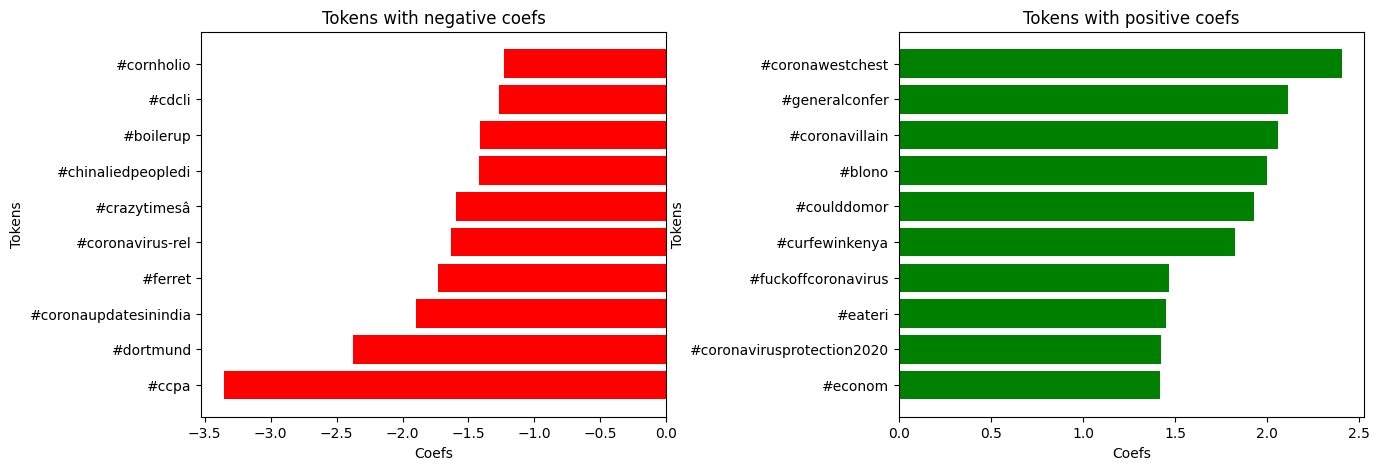

In [ ]:
from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler(with_mean = False)
CVDF_transformed = normalizer.fit_transform(CVDF)

X_train1, X_test1, y_train1, y_test1 = train_test_split(CVDF_transformed, y_train, test_size=0.3, random_state=0)
reg = LogisticRegression(max_iter=1000)

y_train1 = y_train1.astype('int')
y_test1 = y_test1.astype('int')
reg.fit(X_train1, y_train1)
y_pred = reg.predict(X_train1)
y_pred1 = reg.predict(X_test1)
print(f"Accuracy train: {accuracy_score(y_train1, y_pred)}")
print(f"Accuracy test: {accuracy_score(y_test1, y_pred1)}")


names = cv.get_feature_names_out()
coefs = reg.coef_[0]
pos_coefs = coefs[coefs.argsort()[-10:]]
neg_coefs = coefs[coefs.argsort()[:10]]
pos_tokens = names[coefs.argsort()[-10:]]
neg_tokens = names[coefs.argsort()[:10]]


print(pos_tokens, pos_coefs)
print(neg_tokens, neg_coefs)

figure, (chart1, chart0) = plt.subplots(1, 2, figsize=(15, 5))
chart0.barh(pos_tokens, pos_coefs, color = "green")
chart0.set_title('Tokens with positive coefs')
chart0.set_xlabel('Coefs')
chart0.set_ylabel('Tokens')
chart1.barh(neg_tokens, neg_coefs, color = "red")
chart1.set_title('Tokens with negative coefs')
chart1.set_xlabel('Coefs')
chart1.set_ylabel('Tokens')
plt.subplots_adjust(wspace=0.5)




Большее позитивное влияние оказали токены, во-первых, осмысленные, связанные с топиком, во-вторых, достаточно эмоционально окрашенные, в-третьих, это все хештеги. Отрицательные веса у странных хештегов, не несущих особый смысл.

Я очень сомневаюсь, что ScreenName и UserName могут быть хоть как-то полезны, ведь неважно какой закодированный номер у пользователя, это никак не влияет на эмоциональную окраску твита.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
scaler = StandardScaler()
screen = np.array(X_train['ScreenName'])

user = np.array(X_train['UserName'])
enc = OneHotEncoder()
screen_transformed = enc.fit_transform(screen.reshape(-1,1))
user_transformed = enc.fit_transform(user.reshape(-1,1))
print(user_transformed.shape)
XStacked = hstack([CVDF_transformed, screen_transformed, user_transformed])
X_train2, X_test2, y_train2, y_test2 = train_test_split(XStacked, y_train, test_size=0.3, random_state=0)
y_train2 = y_train2.astype('int')
y_test2 = y_test2.astype('int')
model = LogisticRegression(max_iter=1000)
model.fit(X_train2, y_train2)
y_pred = model.predict(X_train2)
y_pred1 = model.predict(X_test2)
print(f"Accuracy: {accuracy_score(y_train2, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test2, y_pred1)}")

(23410, 23410)
Accuracy: 0.9871239397083054
Accuracy: 0.79994304428307


Как я и говорил эти признаки почти ни на что не влияют, качество почти не изменилось

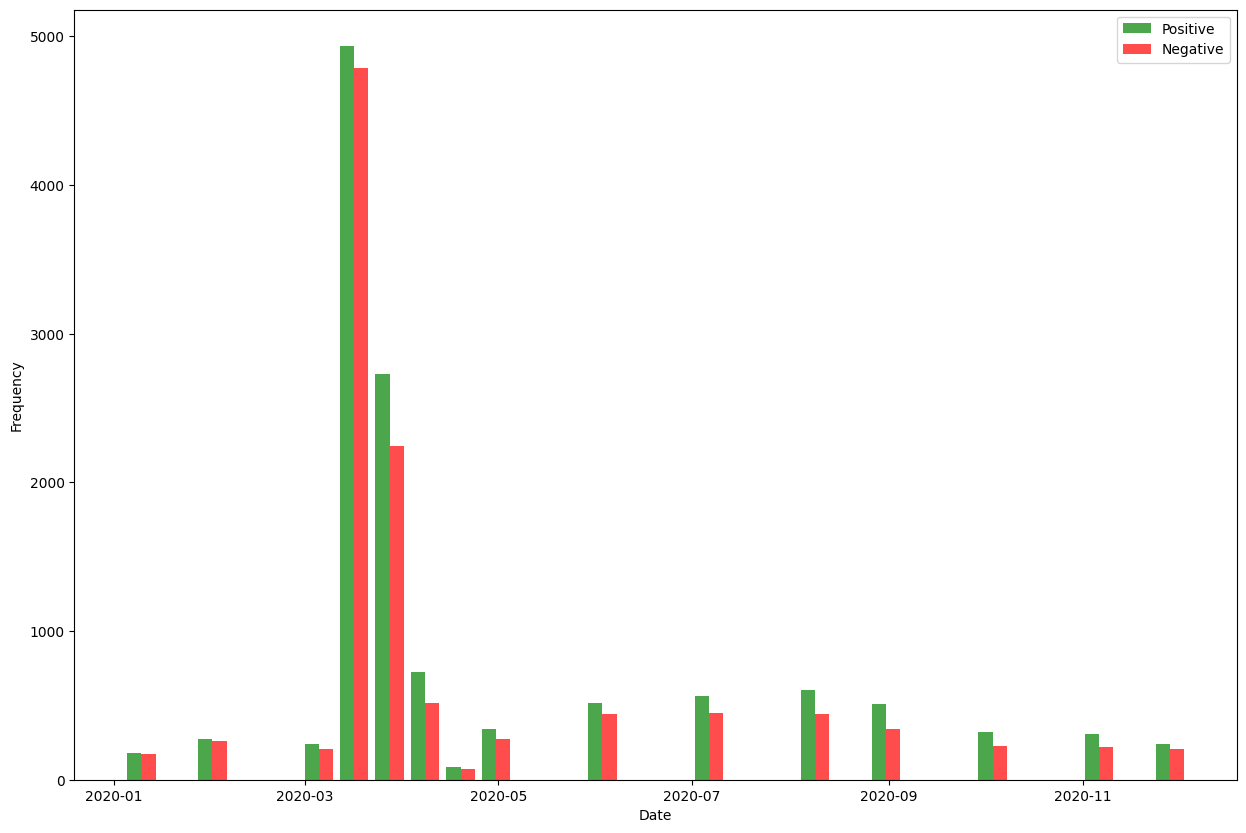

In [ ]:
from datetime import datetime

X_train['TweetAt'] = pd.to_datetime(X_train['TweetAt'],format='mixed')

positive_tweets = X_train.loc[X_train['Sentiment'] == 1, 'TweetAt']
negative_tweets = X_train.loc[X_train['Sentiment'] == 0, 'TweetAt']
plt.figure(figsize=(15, 10))
plt.hist([positive_tweets, negative_tweets], color=['green', 'red'], bins=30, alpha=0.7, label=['Positive', 'Negative'])
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.legend()



Этот признак также не будет полезен, так как ни на одном временном промежутке не выделяется какое-либо из значений целевой переменной. Везде количество отрицательных твитов +- равно количеству положительных.

In [ ]:
len(X_train['Location'].unique())

7950

(array([153., 295., 222., 301., 133., 204., 223., 274., 118., 154.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

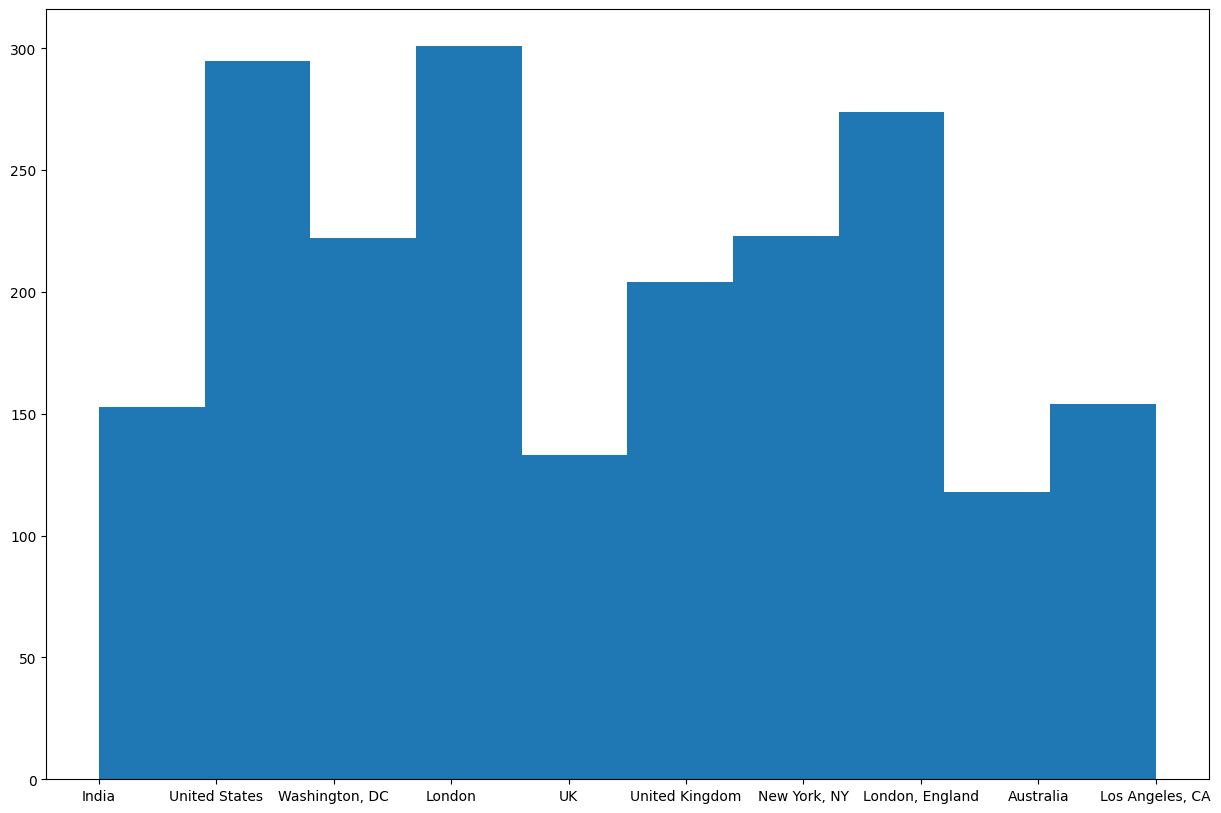

In [ ]:
top10_location = X_train['Location'].value_counts()[1:11].index.tolist()
location_nums = [i for i in X_train['Location'] if i in top10_location]
plt.figure(figsize=(15, 10))

plt.hist(location_nums)






5164


(array([247., 295., 230., 302., 836., 833., 383., 383., 597., 260.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

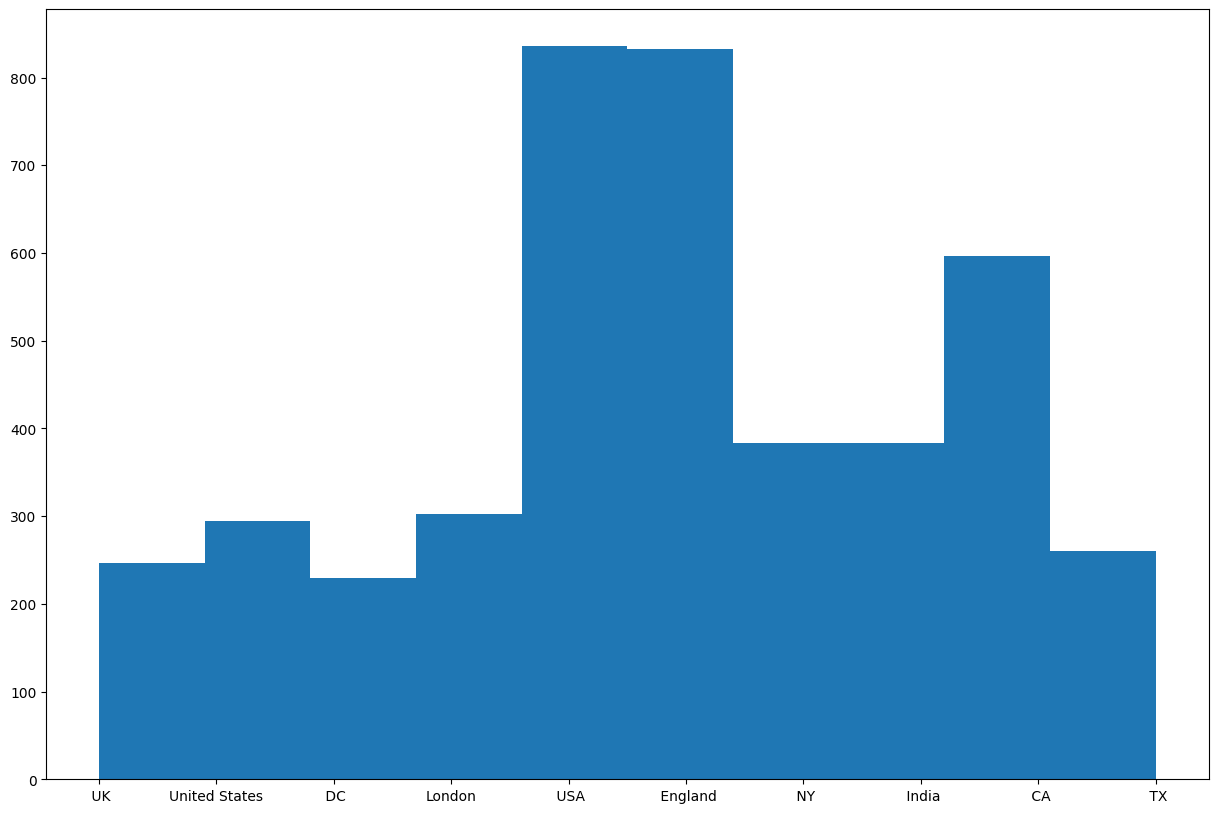

In [ ]:
def widerLocation(location):
  return location.split(',')[-1]
X_train['WiderLocation'] = X_train['Location'].apply(widerLocation)
print(len(X_train['WiderLocation'].unique()))
top10_location = X_train['WiderLocation'].value_counts()[1:11].index.tolist()
location_nums = [i for i in X_train['WiderLocation'] if i in top10_location]
plt.figure(figsize=(15, 10))

plt.hist(location_nums)


In [ ]:
encoder = OneHotEncoder(sparse = False)

values = X_train['WiderLocation'].value_counts()
more_than_1 = values[values > 1].index.tolist()
print("Встречаются более одного раза:", len(more_than_1))
data_dum = pd.get_dummies(X_train['WiderLocation'].apply(lambda x: x if x in more_than_1 else 'Unknown'))

X_encoded = pd.concat([X_train.drop(columns=['WiderLocation']), data_dum], axis=1)




XStacked = hstack([XStacked, data_dum])
X_train2, X_test2, y_train2, y_test2 = train_test_split(XStacked, y_train, test_size=0.3, random_state=0)
y_train2 = y_train2.astype('int')
y_test2 = y_test2.astype('int')
model = LogisticRegression(max_iter=1000)
model.fit(X_train2, y_train2)
y_pred = model.predict(X_train2)
y_pred1 = model.predict(X_test2)
print(f"Accuracy: {accuracy_score(y_train2, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test2, y_pred1)}")




Встречаются более одного раза: 1160
Accuracy: 0.988832611216208
Accuracy: 0.7978072048981917


Данный признак также оказался не особо полезным


Макаров Иван 9 группа